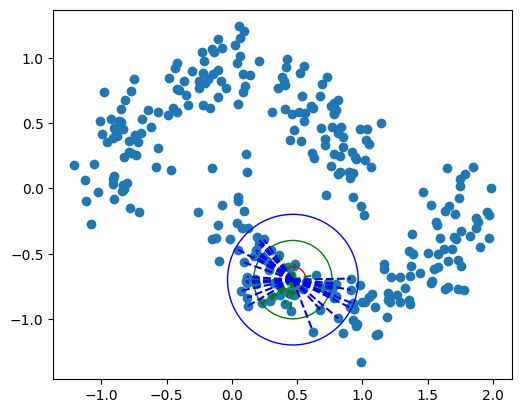

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from util import moon
from sklearn.metrics import pairwise_distances

n, noise = 500, 0.3
data, length = moon(n, noise)
x = data[:, 0]
y = data[:, 1]

DISTANCES = [0.1, 0.3, 0.5]
COLORS = ['r', 'g', 'b']

p_200 = data[250]

distances = pairwise_distances(data, [p_200])

plt.scatter(x, y)

for i, distance in enumerate(DISTANCES):
    circle = plt.Circle((p_200[0], p_200[1]), distance, color=COLORS[i], fill=False)
    plt.gca().add_patch(circle)

    nearby_points = np.where((distances < distance) & (distances >= DISTANCES[i - 1] if i > 0 else 0))[0]
    
    for j in nearby_points:
        if j != 300:
            plt.plot([p_200[0], data[j, 0]], [p_200[1], data[j, 1]], color=COLORS[i], linestyle='--')

plt.gca().set_aspect('equal', adjustable='box')

plt.show()


(200, 200)
1442


  0%|          | 0/1442 [00:00<?, ?it/s]

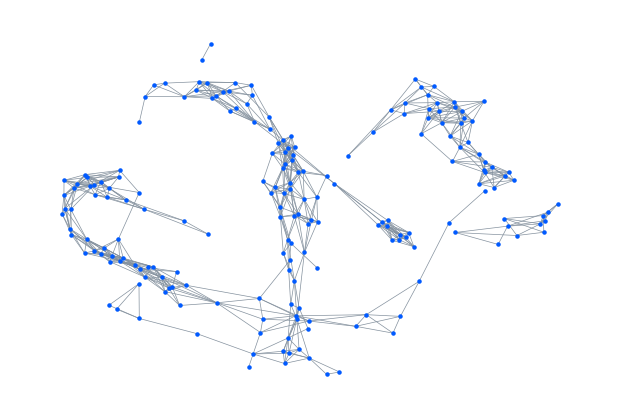

In [9]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.auto import tqdm
import torch

# from util import Net, GIN, GAT, moon, stationary, reconstruct, dG
from util import moon

fig = plt.figure(figsize=(6, 4))

np.random.seed(0)
torch.manual_seed(0)

n = 200
noise = 0.5
DISTANCE = 0.5

x, n = moon(n, noise)
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))

D = pairwise_distances(x)
print(D.shape)

A_binary = np.where((D <= DISTANCE)&(D!=0), 1, 0)

fr, to = np.where(A_binary == 1)
edges = list(zip(fr, to))
print(len(edges))

G = nx.Graph()
G.add_edges_from([(fr[i], to[i]) for i in tqdm(range(len(fr)))])

pos = nx.spring_layout(G, k=0.18, seed=0)
nx.draw(G, pos=pos, node_size=5, node_color='#005aff', edge_color='#84919e', width=0.5)

plt.show()


(5000, 5000)
245018


  0%|          | 0/245018 [00:00<?, ?it/s]

KeyboardInterrupt: 

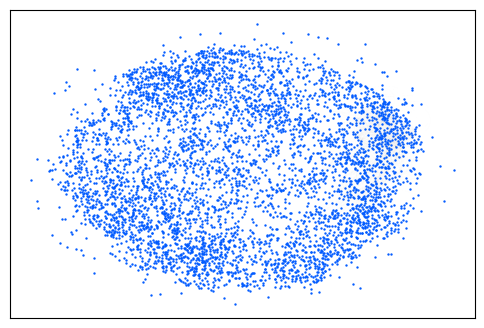

In [3]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import networkx as nx
from tqdm.auto import tqdm
import torch

# from util import Net, GIN, GAT, moon, stationary, reconstruct, dG
from util import moon

# 创建图形
fig = plt.figure(figsize=(6, 4))

np.random.seed(0)
torch.manual_seed(0)

n = 5000
noise = 0.5
DISTANCE = 0.1

# 生成数据
x, n = moon(n, noise)
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))

# 计算距离矩阵
D = pairwise_distances(x)
print(D.shape)

# 创建邻接矩阵
A_binary = np.where(D <= DISTANCE, 1, 0)

fr, to = np.where(A_binary == 1)
edges = list(zip(fr, to))
print(len(edges))

# 创建图
G = nx.DiGraph()
G.add_edges_from([(fr[i], to[i]) for i in tqdm(range(len(fr)))])

# 绘制网络图
pos = nx.spring_layout(G, k=0.18, seed=0)
nx.draw_networkx(G, pos=pos, node_size=0.5, node_color='#005aff', labels={i: '' for i in range(n)}, edge_color='#84919e', width=0.0005, arrowsize=0.1)

# 添加文本
txt = plt.text(0.05, 0.05, 'Input Graph', color='k', fontsize=14, weight='bold', transform=plt.gca().transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

# 显示图像
plt.show()
